In [31]:
import os
from kbmod.image_info import ImageInfoSet, ImageInfo
from glob import glob
from astropy.io import fits
import numpy as np
from astropy.time import Time
import kbmod.search as kb
from kbmod.run_search import run_search
#from parsers.AtlasParser import AtlasParser

In [45]:
from datetime import datetime, timedelta
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import subprocess

import warnings
from astropy.io.fits.verify import VerifyWarning
from astropy.wcs import FITSFixedWarning

# Ignore specific warnings
warnings.simplefilter('ignore', VerifyWarning)
warnings.simplefilter('ignore', FITSFixedWarning)

class ATLASParser():
    
    def __init__(self, working_path, image_type='science', crop_params=None, align=True):
        
        # paths
        self.working_path = working_path
        if not os.path.exists(self.working_path): os.makedirs(self.working_path)
        if not os.path.exists(os.path.join(self.working_path, 'ori/')): os.makedirs(os.path.join(self.working_path, 'ori/'))
        self.ori_image_path = os.path.join(self.working_path, 'ori/')
        if not os.path.exists(os.path.join(self.working_path, 'prep_images/')): os.makedirs(os.path.join(self.working_path, 'prep_images/'))
        self.kbmod_image_path = os.path.join(self.working_path, 'prep_images/')
        if not os.path.exists(os.path.join(self.working_path, 'warped/')): os.makedirs(os.path.join(self.working_path, 'warped/'))
        self.warped_image_path = os.path.join(self.working_path, 'warped/')

        # config parameters
        self.rebinning_factor = 8
        self.image_type = image_type
        self.crop_params = crop_params


    def oversample_array(self, array):
        rows = np.repeat(array, self.rebinning_factor, axis=0)
        return np.repeat(rows, self.rebinning_factor, axis=1)      
    
    
    def correct_header(self, header, new_header):
        header['CTYPE1'] = 'RA---TAN-SIP'
        header['CTYPE2'] = 'DEC--TAN-SIP'
        header['OBS-LAT'] = header['SITELAT']
        header['OBS-LONG'] = header['SITELONG']
        header['OBS-ELEV'] = header['SITEELEV']
        if header['OBSID'][:2] == '01': header['OBSERVAT'] = 'T05'
        elif header['OBSID'][:2] == '02': header['OBSERVAT'] = 'T08'
        elif header['OBSID'][:2] == '03': header['OBSERVAT'] = 'W68'
        elif header['OBSID'][:2] == '04': header['OBSERVAT'] = 'M22'
        header['DATE-AVG'] = (datetime.strptime(header['DATE-OBS'], '%Y-%m-%dT%H:%M:%S%z') +
                              timedelta(seconds=header['EXPTIME']/2)).strftime('%Y-%m-%dT%H:%M:%S')
        header['MJD-AVG'] = header['MJD-OBS'] + header['EXPTIME']/2/86400
        header["IDNUM"] = header['OBSID']
        header['PIXSCALE'] = header['RP_ASCL']
        header['PSF'] = header['FWHM']/2.355

        for key in list(header.keys()):
            if key.startswith('PV'): header.remove(key)

        wcs_keywords = ['CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 
                        'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'RADECSYS', 'EQUINOX', 'LONPOLE', 'LATPOLE']
        header['RADESYSa'] = header['RADECSYS']
        del header['RADECSYS']
        for keyword in wcs_keywords: header[keyword] = new_header[keyword]
        for i in range(1, header['NAXIS']+1):
            for j in range(1, header['NAXIS']+1):
                header.remove(f'PC{i}_{j}', ignore_missing=True)
                header.remove(f'CD{i}_{j}', ignore_missing=True)

        for i in range(1, header['NAXIS']+1):
            for j in range(1, 21):
                header.remove(f'PV{i}_{j}', ignore_missing=True)

        return header
    
    def get_image(self, file, ra=None, dec=None):

        # warp image
        if self.image_type == 'diff':
            ori = file.replace('fits.fz', 'diff.fz')
        else:
            ori = file
        var = file
        res_file = os.path.join(self.warped_image_path, os.path.basename(file).replace('.fits.fz', '.fits'))
        
        # warp image
        self.warp(ori, var, res_file)

        # load image
        print('Getting warped image', end="\r")
        with fits.open(res_file, output_verify='silentfix') as hdul:
            data = hdul[0].data
            new_header = hdul[0].header
        img = data[0,:,:]
        var = data[1,:,:]
        mask = self.create_mask(img)

        print('Correcting header', end="\r")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            header = fits.getheader(file, 1)
        header = self.correct_header(header, new_header)
        
        return img, header, mask, var

    def load_images(self, im_list, save=True):

        print("---------------------------------------")
        print("Loading Images")
        print("---------------------------------------")

        img_info = ImageInfoSet()
        images = []
        visit_times = []
        # del_keys = ['SIMPLE', 'BITPIX', 'NAXIS', 'EXTEND', 'HISTORY', 'COMMENT']
        ra, dec = None, None
        t0 = datetime.utcnow()

        for i,im in enumerate(im_list):

            print(f'{i+1}/{len(im_list)}: {im}')

            sci, header, mask, var = self.get_image(im, ra, dec)
            if i == 0:
                ra, dec = header['RA'], header['DEC']

            # for key in h_wcs.keys():
            #     if key not in del_keys: header[key] = h_wcs[key]
            # header['NAXIS1'] = sci.shape[0]
            # header['NAXIS2'] = sci.shape[1]

            header_info = ImageInfo()
            header_info.populate_from_header(header)
            time_stamp = header['MJD-AVG']
            psf = kb.psf(header['PSF'])

            img = kb.layered_image(kb.raw_image(sci), 
                                    kb.raw_image(var),
                                    kb.raw_image(mask),
                                    time_stamp, psf)
            images.append(img)
            visit_times.append(time_stamp)
            img_info.append(header_info)

            print('Image added to stack', end="\r")

            if save:
                image = [fits.PrimaryHDU(sci, header), fits.PrimaryHDU(mask, header), fits.PrimaryHDU(var, header)]
                if self.image_type == 'diff': lab = [os.path.basename(im).replace('fits.fz','diff.fits')]
                else: lab = [os.path.basename(im).replace('fits.fz','sci.fits')]

                lab += [os.path.basename(im).replace('fits.fz','mask.fits'),
                        os.path.basename(im).replace('fits.fz','var.fits')]
                        
                for h in range(len(image)):
                    image[h].writeto(os.path.join(self.kbmod_image_path, lab[h]), overwrite=True, output_verify='silentfix')

        stack = kb.image_stack(images)

        # Create a list of visit times and visit times shifted to 0.0.
        img_info.set_times_mjd(np.array(visit_times))
        times = img_info.get_zero_shifted_times()
        stack.set_times(times)
        te = (datetime.utcnow() - t0).total_seconds()
        print("Stack created, time elapsed: %.1f s" % te, end="\r")

        self.stack = stack
        self.img_info = img_info
        return stack, img_info


    def warp(self, image_file, var_file, res_file):

        print('Warping image', end="\r")

        # get center coordinates
        center_ra = self.crop_params['center_coords'][0]
        center_dec = self.crop_params['center_coords'][1]
        nx = self.crop_params['crop_size']
        ny = self.crop_params['crop_size']

        # executable path
        warpsky_path = "../parsers/warpsky"
        command = [warpsky_path, image_file, res_file, '-var', var_file,'-r0', str(center_ra), '-d0', str(center_dec), '-cx', '0', '-cy', '0']
        if nx is not None:
            command += ['-nx', str(nx), '-ny', str(ny)]

        result = subprocess.run(command, capture_output=True, text=True)

    def create_mask(self, img):
        mask = np.zeros(img.shape)
        mask[img < -200] = 1
        return mask

    @staticmethod
    def crop_image(im, header, coords, size=1000):
        wcs = WCS(header)
        center_coord = SkyCoord(coords[0], coords[1], unit=(u.deg, u.deg), frame='icrs')
        center_px = wcs.all_world2pix(center_coord.ra, center_coord.dec, 0)
        cutout = Cutout2D(im, center_px, size*u.pixel, wcs=wcs)
        cropped_data = cutout.data
        cropped_wcs = cutout.wcs
        header.update(cropped_wcs.to_header())
        return cropped_data, header
    

    @staticmethod
    def center(im, header, coords, size=1000):
        if type(coords[0]) == float:
            wcs = WCS(header)
            center_coord = SkyCoord(coords[0], coords[1], unit=(u.deg, u.deg), frame='icrs')
            coords = wcs.all_world2pix(center_coord.ra, center_coord.dec, 0)
        return im[int(coords[0]-size/2):int(coords[0]+size/2), int(coords[1]-size/2):int(coords[1]+size/2)]


    @staticmethod
    def astrometrize(sources, im_shape, scale):
        ast = AstrometryNet()
        image_width = im_shape[0]
        image_height = im_shape[1]
        h_wcs = ast.solve_from_source_list(sources[:,0], sources[:,1],
                                            image_width, image_height,
                                            tweak_order=3, solve_timeout=180,
                                            scale_est = scale, scale_err = scale*0.1,
                                            scale_units = 'arcsecperpix')
        return h_wcs
    
    @staticmethod
    def arcsecmin_to_pxday(arcsecmin, pxsize=1.86):
        return arcsecmin/pxsize*60*24
    

    @staticmethod
    def dyn_avgstd(valuenew, nold, avgold, stdold):
        nnew = nold + (valuenew != 0).astype(np.int)
        if np.sum(nold) == 0:
            avgnew = np.asarray(valuenew, dtype=np.double)
            stdnew = np.zeros_like(valuenew, dtype=np.double)
        else:
            avgnew = avgold + (valuenew - avgold) / nnew
            stdnew = np.sqrt(
                nold/nnew * stdold**2 +
                (valuenew - avgnew) * (valuenew - avgold) / nnew
                )
        return nnew, avgnew, stdnew


In [46]:
results_suffix = "atlas_test"
img_typ = 'diff'
working_path = '/app/images/KBMOD/'
res_filepath = '/app/data/atlas'

crop_params = {'center_coords': ((20+50/60+17.6/3600)*15, 28+36/60+12/3600),
                'crop_size': 2048}

crop_params = {'center_coords': ((1+8/60+21.5/3600)*15, 16+26/60+5/3600),
                 'crop_size': 2048}

ATLAS_Parser = ATLASParser(working_path, image_type=img_typ, crop_params=crop_params)
sci_filelist = glob(os.path.join(ATLAS_Parser.ori_image_path, '*59841*.fits.fz'))
sci_filelist.sort()
sci_filelist = sci_filelist


stack, img_info = ATLAS_Parser.load_images(sci_filelist)

---------------------------------------
Loading Images
---------------------------------------
1/4: /app/images/KBMOD/ori/02a59841o0360o.fits.fz
INFO: ting headerage
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
 

In [39]:
img_array = np.zeros((stack.img_count(), 2048, 2048))
mask_array = np.zeros((stack.img_count(), 2048, 2048))
var_array = np.zeros((stack.img_count(), 2048, 2048))
for i,ima in enumerate(stack.get_images()):
    img_array[i,:] = ima.get_science()
    mask_array[i,:] = ima.get_mask()
    var_array[i,:] = ima.get_variance()

div = np.std(img_array, axis=0)

ATLAS_Parser = ATLASParser(working_path, image_type=img_typ, crop_params=crop_params, div=div)



In [54]:



v_min = ATLAS_Parser.arcsecmin_to_pxday(0.3)
v_max = ATLAS_Parser.arcsecmin_to_pxday(6)
v_steps = 200
v_arr = [v_min, v_max, v_steps]
#vr = ATLAS_Parser.arcsecmin_to_pxday(0.63)
#v_arr = [vr, vr, 1]


# and angles [0.5, 0.5]
ang_below = np.pi
ang_above = np.pi
ang_steps = 50
ang_arr = [ang_below, ang_above, ang_steps]
#ang_arr = [0, 0, 1]

# There are 10 images in the demo data. Make sure we see
# the object in at least 7.
num_obs = int(len(sci_filelist) * 0.75)

input_parameters = {
    # Required
    "im_filepath": res_filepath,
    "res_filepath": res_filepath,
    "time_file": None,
    "output_suffix": results_suffix,
    "v_arr": v_arr,
    "ang_arr": ang_arr,
    # Important
    "num_obs": num_obs,
    "do_mask": True, 
    "lh_level": 10.0,
    #"mask_grow": 5,
    "gpu_filter": True,  #w & w/
    # Fine tuning
    #"sigmaG_lims": [15, 60],
    #"mom_lims": [37.5, 37.5, 1.5, 1.0, 1.0],
    "do_clustering": True,
    "do_stamp_filter": True,
    "num_cores": 20,
    #"peak_offset": [3.0, 3.0],
    #"chunk_size": 1000000,
    #"stamp_type": "cpp_median",
    "eps": 5/2048,
    #"clip_negative": True,
    #"mask_num_images": 10,
    "cluster_type": "position",
    # Override the ecliptic angle for the demo data since we
    # know the true angle in pixel space.
    "average_angle": np.pi#290 * np.pi / 180.0,
}

rs = run_search(input_parameters, sci_filelist, ATLAS_Parser)
rs.run_search()

---------------------------------------
Loading Images
---------------------------------------
1/4: /app/images/KBMOD/ori/02a59841o0360o.fits.fz
INFO: ting headerage
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
 

In [114]:
img_info

NameError: name 'img_info' is not defined

In [19]:
from kbmod.filters.clustering_filters import DBSCANFilter

average_angle = np.pi
ang_min = average_angle - ang_below
ang_max = average_angle + ang_above

cluster_params = {}
cluster_params["x_size"] = 2048
cluster_params["y_size"] = 2048
cluster_params["vel_lims"] = [v_min, v_max]
cluster_params["ang_lims"] = [ang_min, ang_max]
cluster_params["mjd"] = np.array(img_info.get_all_mjd())

f = DBSCANFilter(
    'position',
    0.03,
    cluster_params["x_size"],
    cluster_params["y_size"],
    cluster_params["vel_lims"],
    cluster_params["ang_lims"],
    cluster_params["mjd"],
)

NameError: name 'img_info' is not defined

In [40]:
cluster_params

{'x_size': 2048,
 'y_size': 2048,
 'vel_lims': [232.25806451612902, 2322.5806451612902],
 'ang_lims': [0.0, 6.283185307179586],
 'mjd': array([60000.47324156, 60000.47735926, 60000.48451256, 60000.49451336])}

-- --
ANALYSIS
-- --

In [55]:
from kbmod.analysis.plot_results import *
from kbmod.image_info import *
from kbmod.result_list import *

results = load_result_list_from_files(res_filepath, results_suffix)
print(f"Loaded {results.num_results()} results.")

Loaded 325 results.


Finding positions of trajectory lh: 17.163818 flux: 586.427856 x: 1946 y: 881 x_v: -2397.589111 y_v: 302.885284 obs_count: 4


(3.121499787993318, 82.80001547219518)

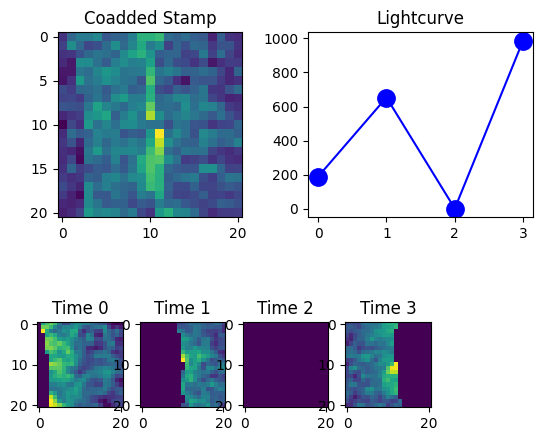

In [60]:
res_index = 20
row0 = results.results[res_index]
ResultsVisualizer.plot_result_row(row0)
trj0 = row0.trajectory
print(f"Finding positions of trajectory {trj0}")

x_v= trj0.x_v
y_v= trj0.y_v

vel = np.sqrt(x_v**2 + y_v**2)
pa = (np.arctan2(-x_v, y_v)) * 180/np.pi 
if pa < 0: pa += 360
vel*1.86/24/60, pa

In [78]:
def run_warpsky(center_ra, center_dec, ori, res, var):
    warpsky_path = "../parsers/warpsky"
    command = [warpsky_path, ori, res, '-var', var, '-r0', str(center_ra), '-d0', str(center_dec), '-cx', '0', '-cy', '0']
    result = subprocess.run(command, capture_output=True, text=True)

In [77]:
var = sci_filelist[-1]
ori = var.replace('.fits', '.diff')
res = ori.replace('ori', 'warped')[:-3]
center_ra = fits.getheader(ori, 1)['RA']
center_dec = fits.getheader(ori, 1)['DEC']

In [80]:
run_warpsky(center_ra, center_dec, ori, res, var)#, res, ori)

In [81]:
fits.info(res)

Filename: /app/images/KBMOD/warped/02a60000o0422c.diff
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (10478, 10478, 2)   float32   


In [84]:
d = fits.getdata(res, 0)

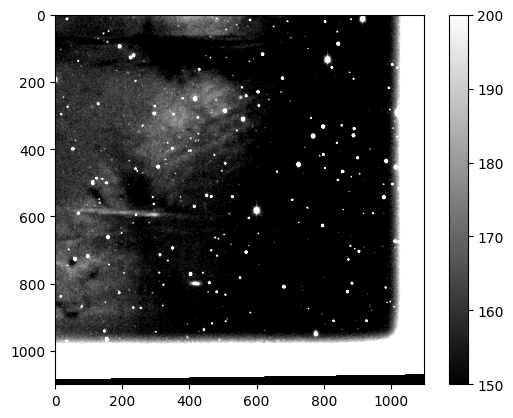

In [102]:
from matplotlib import pyplot as plt
plt.imshow(d[1,-1100:,-1100:], vmin=150, vmax=200, cmap='gray')
plt.colorbar()
plt.show()

In [104]:
WCS(fits.getheader(res))

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  ''  
CRVAL : 159.86076  10.47541  0.0  
CRPIX : 5239.5  5239.5  0.0  
CD1_1 CD1_2 CD1_3  : -0.000517313126748944  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  0.000517313126748944  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  1.0  
NAXIS : 10478  10478  2

In [9]:
stack, img_info = ATLAS_Parser.load_images(sci_filelist)

---------------------------------------
Loading Images
---------------------------------------
1/4: /app/images/KBMOD/ori/02a60000o0379c.fits.fz
INFO: ting headerage
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
 

In [555]:
img_array = np.zeros((stack.img_count(), 2048, 2048))
mask_array = np.zeros((stack.img_count(), 2048, 2048))
var_array = np.zeros((stack.img_count(), 2048, 2048))
for i,ima in enumerate(stack.get_images()):
    img_array[i,:] = ima.get_science()
    mask_array[i,:] = ima.get_mask()
    var_array[i,:] = ima.get_variance()

mask = np.zeros((2048, 2048))
mask[mask_array.sum(axis=0) > 0] = 1
mask[np.max(np.abs(img_array), axis=0) > 1e4] = 0
#mask = mask.astype(bool)

In [464]:
stack.get_images()

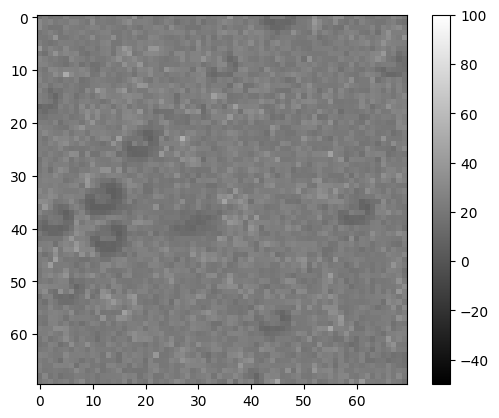

In [556]:

x0, y0 = 1728, 1035 #1207, 845
size = 70
data = img_array[0, int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]
var = var_array[0, int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]
#data -= mask[int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]*1e5
plt.imshow(data-mask[int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]*1e5, cmap='gray', vmin=-50, vmax=100, origin='upper')
plt.colorbar()

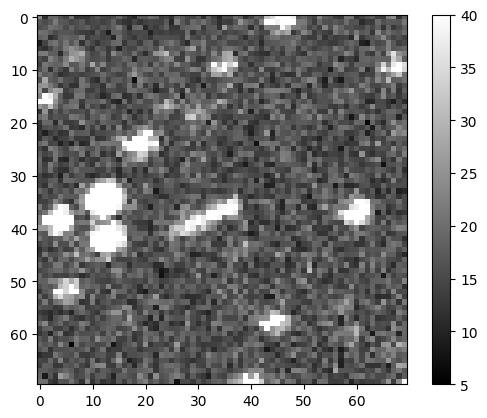

In [497]:
thres = 25
std = np.std(img_array[:, int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)], axis=0)
std[std ==0] = 1e5
std += mask[int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]*1e5

plt.imshow(std, cmap='gray', vmin=5, vmax=40)
plt.colorbar()

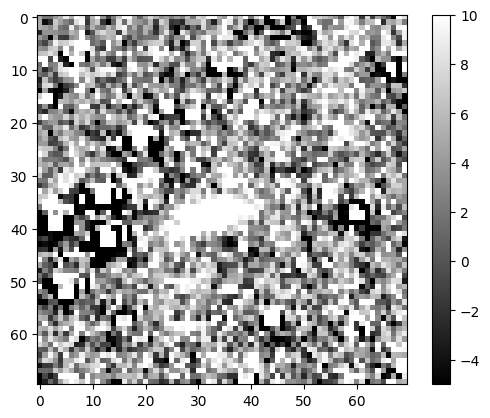

In [468]:
mean = np.mean(img_array[:, int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)], axis=0)
mean -= mask[int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]*1e5

plt.imshow(mean, cmap='gray', vmin=-5, vmax=10)
plt.colorbar()

In [523]:
3/np.sqrt(2)

2.1213203435596424

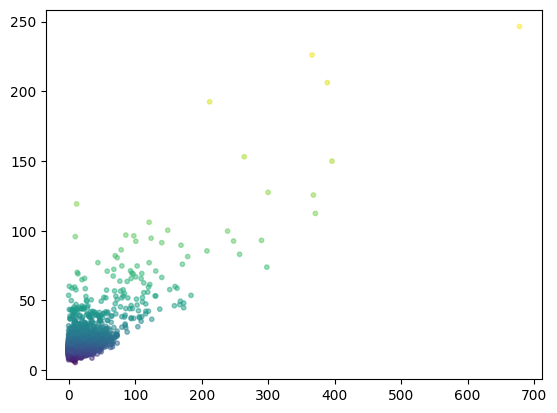

In [469]:
# plot scatter data vs std in color log scale

x= np.abs(data[std < 1e3])
y = std[std < 1e3]

plt.scatter(x, y, c=np.log10(y), cmap='viridis', s=10, alpha=0.5)



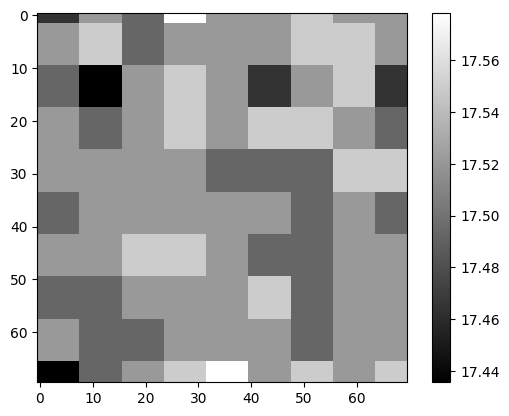

In [470]:
plt.imshow(np.sqrt(var), cmap='gray')#, vmin=0, vmax=5)
plt.colorbar()

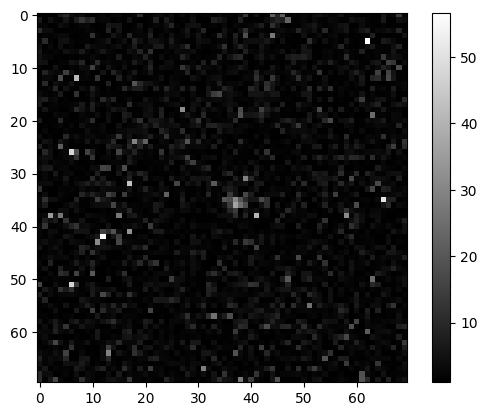

In [541]:
n = stack.img_count()
#std = np.std(img_array[:, int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)], axis=0)
#std[std ==0] = 1e5
#std += mask[int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]*1e5

thres = (n / np.sqrt(n-1))
mm = np.abs(data)/std

plt.imshow(mm, cmap='gray', vmin=0, vmax=0.75*thres)
plt.colorbar()

In [518]:
mm

array([[0.29412841, 0.08745739, 0.15657571, ..., 1.19943243, 2.66535848,
        0.71784964],
       [1.85734753, 0.        , 1.53441018, ..., 0.23352928, 1.4901061 ,
        1.22436592],
       [0.88901635, 0.77332316, 0.        , ..., 0.54254372, 0.39678668,
        0.1086619 ],
       ...,
       [1.083522  , 1.77501778, 0.12056926, ..., 0.10744097, 0.89377496,
        1.17859386],
       [2.32628778, 1.28005918, 1.36255669, ..., 0.60981961, 0.7147376 ,
        0.73363221],
       [2.34745251, 0.45112557, 1.8214981 , ..., 0.29407191, 1.16073616,
        1.67439697]])

In [521]:
bck_mask = np.abs(data) < np.sqrt(var)

bck = np.median(data[bck_mask])
bck_sigma = np.std(data[bck_mask])

P = 5
n = stack.img_count()

res_mask = (mm<P*thres) & (np.abs(data)>3*bck_sigma)

print(np.prod(data.shape), np.sum(res_mask))

4900 892


In [478]:
bck_sigma  

9.371243412150383

In [538]:
res_mask = (data > -np.sqrt(var)) & (data < np.sqrt(var))
res_mask = (np.abs(data)/std < 1+(thres-1)*0.5) & (np.abs(data)>5*bck_sigma)

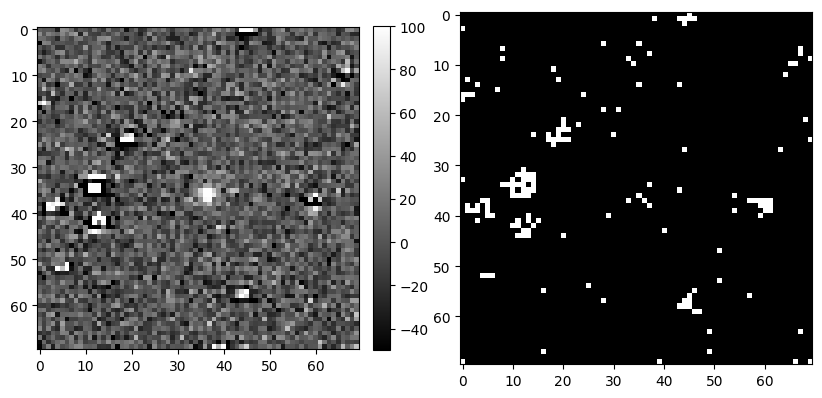

In [539]:
# plot data and mask

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = ax[0].imshow(data, cmap='gray', vmin=-50, vmax=100)
# add colorbar
plt.colorbar(g, fraction=0.046, pad=0.04)

ax[1].imshow(res_mask, cmap='gray', vmin=0, vmax=1)

In [334]:
P*n/np.sqrt(n-1)

2.806243040080456

In [7]:
DIFF = np.zeros((len(sci_filelist), 2048, 2048))
for i,file in enumerate(sci_filelist):
    img, header, mask, var, diff = ATLAS_Parser.get_image(file)
    DIFF[i,:] = diff

 [astropy.io.fits.verify]


ValueError: could not broadcast input array from shape (2456,2456) into shape (2048,2048)

In [42]:
AstrometryNet().api_key

'ruavrmwepqfvhdqm'

In [26]:
with fits.open(im, output_verify='silentfix') as hdul:
    img = hdul[1].data
    mask = hdul[2].data

In [51]:
sci_filelist


['/app/images/KBMOD/ori/02a60000o0379c.fits.fz',
 '/app/images/KBMOD/ori/02a60000o0387c.fits.fz',
 '/app/images/KBMOD/ori/02a60000o0401c.fits.fz',
 '/app/images/KBMOD/ori/02a60000o0422c.fits.fz']

In [223]:
st_ori, img_info = rs.Parser.load_images(sci_filelist, save=True)

---------------------------------------
Loading Images
---------------------------------------
1/4: /app/images/KBMOD/ori/02a60000o0379c.fits.fz
INFO: ting headerage
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
 

In [136]:
type(st_ori)


kbmod.search.image_stack

In [133]:
from copy import deepcopy

In [187]:
2.65/2.355

1.1252653927813163

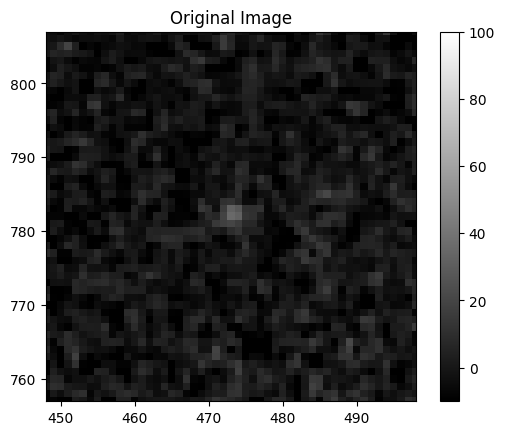

In [261]:
stack = st_ori
im = stack.get_images()[-1]
a = im.get_science()
x_center, y_center = 473, 782
area = 50
plt.imshow(a, cmap="gray", vmin=-10, vmax=100)
plt.title("Original Image")
plt.xlim(x_center-area/2, x_center+area/2)
plt.ylim(y_center-area/2, y_center+area/2)
plt.colorbar()

In [265]:
print(np.median(a.get_all_pixels()), np.std(a.get_all_pixels()))
print(np.median(b.get_all_pixels()), np.std(b.get_all_pixels()))

-0.015821977518498898 2.4320935910540027
0.00039681133057456464 2.2795236071319825e-05


1.0789384841918945


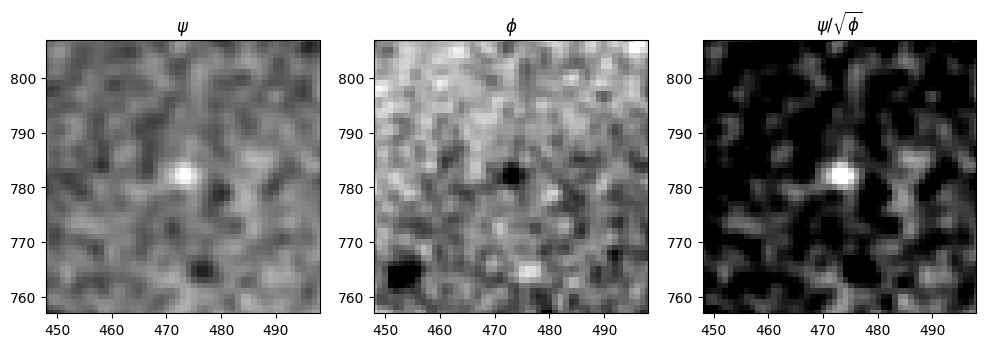

In [279]:
# im = st_ori.get_images()[1]
psf = im.get_psf().get_stdev()
print(psf)
im.set_psf(kb.psf(psf))
a = im.generate_psi_image()
b = im.generate_phi_image()

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(a, cmap='gray', vmin=-.1, vmax=.1)
ax[1].imshow(b, cmap='gray', vmin=0.00037, vmax=0.00041)
ax[2].imshow(a/np.sqrt(b), cmap='gray', vmin=-1, vmax=4,)
labs = [r'$\psi$', r'$\phi$', r'$\psi/\sqrt{\phi}$']


for i in range(3):
    ax[i].set_xlim([x_center-area/2, x_center+area/2])
    ax[i].set_ylim([y_center-area/2, y_center+area/2])
    ax[i].set_title(labs[i])


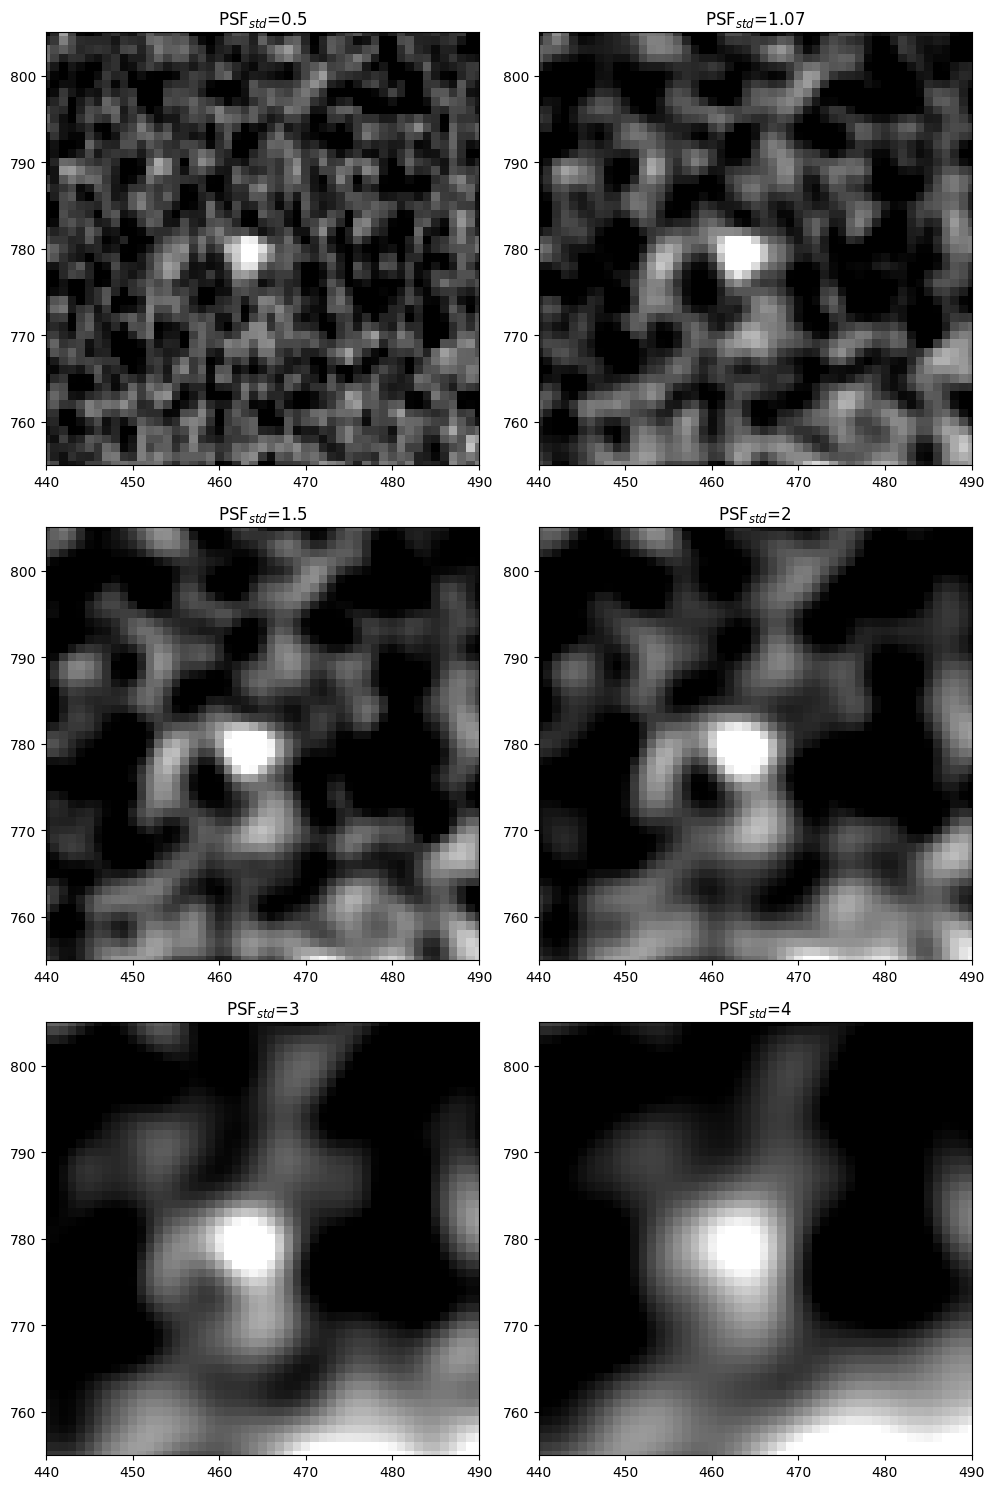

In [225]:
fig, ax = plt.subplots(3,2, figsize=(10,15))
psf_array = [0.5, 1.07, 1.5, 2, 3, 4]

for i,psf in enumerate(psf_array):
    im = st_ori.get_images()[0]
    im.set_psf(kb.psf(psf))
    a = im.generate_psi_image()
    b = im.generate_phi_image()
    img = ax[i//2, i%2].imshow(a/np.sqrt(b), cmap="gray", vmin=-1, vmax=4)
    ax[i//2, i%2].set_title(r'PSF$_{std}$='+str(psf))
    ax[i//2, i%2].set_xlim([x_center-area/2, x_center+area/2])
    ax[i//2, i%2].set_ylim([y_center-area/2, y_center+area/2])


fig.tight_layout()

In [91]:
psf_kernel = np.array([[0.00042652, 0.00052738, 0.00097838, 0.00112309, 0.00158336,
         0.0016751 , 0.00140083, 0.0007724 , 0.00079965],
        [0.00021876, 0.00107289, 0.00220688, 0.00450126, 0.00553412,
         0.00488591, 0.0031191 , 0.00112619, 0.00048173],
        [0.0008282 , 0.00236398, 0.00779977, 0.01766621, 0.02240861,
         0.01803395, 0.0081634 , 0.00253804, 0.00093612],
        [0.00097769, 0.0043783 , 0.01982922, 0.06072872, 0.07278261,
         0.04563654, 0.01622331, 0.00382515, 0.0012349 ],
        [0.00096178, 0.00488396, 0.02338596, 0.07814466, 0.11070463,
         0.0735097 , 0.02405481, 0.00546485, 0.00152598],
        [0.0009763 , 0.00301376, 0.01390835, 0.04314648, 0.07351017,
         0.05821257, 0.02069398, 0.00546595, 0.00105739],
        [0.00058731, 0.00166617, 0.00604943, 0.01540031, 0.02433023,
         0.0218684 , 0.01046884, 0.0031474 , 0.00102326],
        [0.00024802, 0.00095716, 0.00208563, 0.00420922, 0.00642536,
         0.00621934, 0.00338536, 0.00124712, 0.00053333],
        [0.00048246, 0.00040518, 0.00094373, 0.00144277, 0.00208587,
         0.00134638, 0.00115899, 0.00046526, 0.00040786]])

In [92]:
psf_kernel.shape

(9, 9)

In [ ]:
with fits.open(im, output_verify='silentfix') as hdul:
    img = hdul[1].data
    mask = hdul[2].data

In [90]:
psf_kernel.shape

(22, 22)

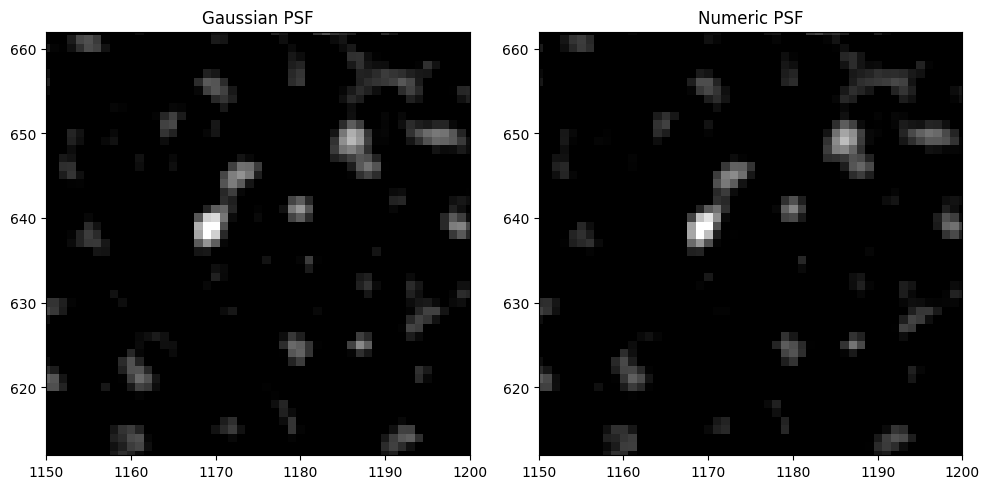

In [104]:
fig, ax = plt.subplots(1,2, figsize=(10,7))
im = st_ori.get_images()[0]

# 2d gaussian filter
a = im.generate_psi_image()
b = im.generate_phi_image()
img = ax[0].imshow(a/np.sqrt(b), cmap="gray", vmin=0, vmax=4)
ax[0].set_title(r'Gaussian PSF')
ax[0].set_xlim([x_center-area/2, x_center+area/2])
ax[0].set_ylim([y_center-area/2, y_center+area/2])

# numeric psf
im.set_psf(kb.psf(psf_kernel))
a = im.generate_psi_image()
b = im.generate_phi_image()
img = ax[1].imshow(a/np.sqrt(b), cmap="gray", vmin=0, vmax=4)
ax[1].set_title(r'Numeric PSF')
ax[1].set_xlim([x_center-area/2, x_center+area/2])
ax[1].set_ylim([y_center-area/2, y_center+area/2])


fig.tight_layout()


In [8]:
sci, header, mask, var, diff = ATLAS_Parser.get_image(sci_filelist[0])

 [astropy.io.fits.verify]


In [9]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [6]:
stack, img_info = ATLAS_Parser.load_images(sci_filelist, save=True)

---------------------------------------
Loading Images
---------------------------------------


 [astropy.io.fits.verify]


Solving........Times set


In [9]:
center_pixel = (img_info.stats[0].width / 2, img_info.stats[0].height / 2)
(img_info.stats[0].wcs, center_pixel)

(WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
 CRVAL : 17.7390340423  16.883187275  
 CRPIX : 1343.74494575  1034.75033873  
 CD1_1 CD1_2  : 0.000514216988835  -3.68872386946e-06  
 CD2_1 CD2_2  : -1.95377933249e-06  -0.00051739987071  
 NAXIS : 10560  10560,
 (5280.0, 5280.0))

In [24]:
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                10560 / length of data axis 1                          
NAXIS2  =                10560 / length of data axis 2                          
TIMESYS = 'UTC'                / Time System for DATExxxx                       
MJD-OBS =       60145.60558025 / [UTC MJD] start of exposure (DFM)              
MJD-CAM =     60145.6055765046 / [UTC MJD] camera shutter open time             
CTRLID  = '005468867071B054'   / controller backplane ID                        
EXPTIME =              30.0000 / [sec] Exposure time                            
DARKWAIT=                  0.6 / [sec] Time from shutter close to readout       
DARKTIME=                 30.6 / [sec] Net dark current time                    
PRESKIP1=                   

(1.9469998155519581, -146.00000887175688)

In [145]:
ATLAS_Parser.arcsecmin_to_pxday(0.58)

449.0322580645161

In [56]:
trj0 = row0.trajectory
sky_pos = ATLAS_Parser.img_info.trajectory_to_skycoords(trj0)
for i, pos in enumerate(sky_pos):
    print(f"{i}: ({pos.ra.degree}, {pos.dec.degree})")
    ra_str = pos.ra.to_string(unit=u.hourangle, sep=':', pad=True, precision=2)
    dec_str = pos.dec.to_string(unit=u.degree, sep=':', alwayssign=True, pad=True, precision=1)
    print(f"{i}: ({ra_str}, {dec_str})")

0: (160.04872505732757, 9.324236235506373)
0: (10:40:11.69, +09:19:27.3)
1: (160.04654435269924, 9.324610004162476)
1: (10:40:11.17, +09:19:28.6)
2: (160.04275598745954, 9.32525930550834)
2: (10:40:10.26, +09:19:30.9)
3: (160.03745953504037, 9.326167046412907)
3: (10:40:08.99, +09:19:34.2)


In [65]:
trj0 = row0.trajectory
print(f"Finding positions of trajectory {trj0}")

slice = 200
d = np.zeros((trj0.obs_count, 2*slice, 2*slice))
for i,image in enumerate(sci_filelist):
    data = fits.getdata(image, 1)
    d[i,:] = data[trj0.x-slice:trj0.x+slice, trj0.y-slice:trj0.y+slice]



Finding positions of trajectory lh: 935.754822 flux: 49215.039062 x: 711 y: 935 x_v: -71.251747 y_v: -404.088867 obs_count: 12


KeyboardInterrupt: 

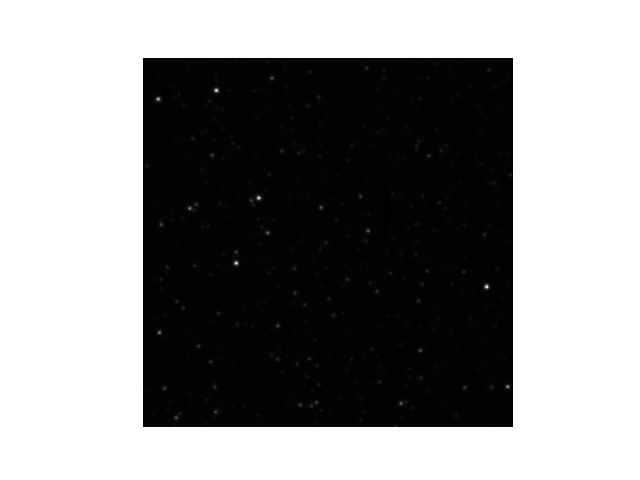

In [61]:
import matplotlib.pyplot as plt
import numpy as np
try: import imageio
except:
    !pip install imageio
    import imageio
from IPython.display import Image, display
try: import cv2
except:
    !pip install opencv-python
    import cv2

# Normalize images for better contrast
min_val = np.median(d[0]) - 2*np.std(d[0])
max_val = np.median(d[0]) + 2*np.std(d[0])
d = (d - min_val) / (max_val - min_val)

# Create a figure and an axis in matplotlib
fig, ax = plt.subplots()
images = []

for i in range(d.shape[0]):
    im = ax.imshow(d[i], animated=True, cmap='gray')
    plt.axis('off')
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
plt.close()

#images_resized = [cv2.resize(img, (400, 400)) for img in images]
imageio.mimsave('animation.gif', images)
with open('animation.gif','rb') as f:
    display(Image(data=f.read(), format='png'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 3.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python3.8 -m pip install --upgrade pip


In [298]:
stack.get_images()[0].get_header()

AttributeError: 'kbmod.search.layered_image' object has no attribute 'get_header'

In [296]:
if os.path.exists(ATLAS_Parser.kbmod_image_path):
    if os.path.exists(os.path.join(ATLAS_Parser.kbmod_image_path, "out/")) is False:
        os.mkdir(os.path.join(ATLAS_Parser.kbmod_image_path, "out/"))


    search.save_psi_phi(os.path.join(ATLAS_Parser.kbmod_image_path, "out"))
else:
    print("Data directory does not exist. Skipping file operations.")


FITSIO status = 105: couldn't create the named file
failed to find or open the following file: (ffopen)
app/data/demo/000000.fits
failed to find or open the following file: (ffopen)
../data/demo/000000.fits
failed to create new file (already exists?):
/app/images/KBMOD/prep_images/out/psi/PSI0000.fits

FITSIO status = 105: couldn't create the named file

FITSIO status = 105: couldn't create the named file

FITSIO status = 115: NULL input pointer

FITSIO status = 105: couldn't create the named file
failed to create new file (already exists?):
/app/images/KBMOD/prep_images/out/phi/PHI0000.fits

FITSIO status = 105: couldn't create the named file

FITSIO status = 105: couldn't create the named file

FITSIO status = 115: NULL input pointer

FITSIO status = 105: couldn't create the named file
failed to create new file (already exists?):
/app/images/KBMOD/prep_images/out/psi/PSI0001.fits

FITSIO status = 105: couldn't create the named file

FITSIO status = 105: couldn't create the named fil

In [212]:
fits.info(os.path.join(ATLAS_Parser.kbmod_image_path, os.path.basename(sci_filelist[0]).replace('fits.fz','layered.fits')))

Filename: /app/images/KBMOD/prep_images/01a58668o0403o.layered.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  image         1 ImageHDU       412   (10560, 10560)   int16   
  2  image         1 ImageHDU       414   (10560, 10560)   int16 (rescales to uint16)   
  3  image         1 ImageHDU       414   (10560, 10560)   int16 (rescales to uint16)   


In [15]:
filename = sci_filelist[0]

filename.rsplit("/")[-1].split(".")[0]

'01a58668o0403o'

In [226]:
file_path = sci_filelist[0]
diff = ATLAS_Parser.uncompress_atlas_data(file_path.replace('.fits.fz', '.diff.fz'), type='diff')[0]
sci, mask, var = ATLAS_Parser.uncompress_atlas_data(file_path, type='science')

layered = [diff, mask, var]
HDU = fits.HDUList(layered)

In [16]:
sci

NameError: name 'sci' is not defined

In [178]:
# load atlas image
img_path = sci_filelist[0]
header = fits.getheader(img_path,1)

image_info = ImageInfo()
image_info.populate_from_fits_file(img_path)

image_info.set_epoch(Time(header['MJD-OBS'], format="mjd", scale="utc"))
image_info.set_obs_code(header['OBSERVAT'])
image_info.set_obs_position(header['OBS-LONG'], header['OBS-LAT'], header['OBS-ELEV'])
image_info.set_layered_image(fits.getdata(img_path,1))

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [194]:
fits.i
info('/app/data/demo/000000.fits')
    

Filename: /app/data/demo/000000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1                1 ImageHDU        22   (256, 256)   float32   
  2                1 ImageHDU         7   (256, 256)   float32   
  3                1 ImageHDU         7   (256, 256)   float32   


In [189]:
fits.getheader('/app/data/demo/000000.fits',2)


im = kb.layered_image('/app/data/demo/000000.fits', kb.psf(1.5))

Help on layered_image in module kbmod.search object:

class layered_image(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      layered_image
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: kbmod.search.layered_image, arg0: str, arg1: kbmod.search.psf) -> None
 |      
 |      2. __init__(self: kbmod.search.layered_image, arg0: kbmod.search.raw_image, arg1: kbmod.search.raw_image, arg2: kbmod.search.raw_image, arg3: float, arg4: kbmod.search.psf) -> None
 |      
 |      
 |                  Creates a layered_image out of individual `raw_image` layers.
 |      
 |                  Parameters
 |                  ----------
 |                  sci : `raw_image`
 |                      The `raw_image` for the science layer.
 |                  var : `raw_image`
 |                      The `raw_image` for

In [190]:
im.get_time()

57130.19921875

In [164]:
header['MJD-OBS']

58668.43258985

-- --
CHECK RESIDUALS
-- --

In [24]:
from astroquery.vizier import Vizier
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord, angles

from astropy import units as u

def __getVizierALL(catalog):
    Vizier.ROW_LIMIT = -1
    results = Vizier.get_catalogs([catalog])
    table = results[0]
    return table


def __getVizier(catalog,radec,radii,maglimit):

    # Gaia catalog I/345/gaia2 columns=['RA_ICRS', 'DE_ICRS', 'Gmag', 'e_Gmag']
    # vizier_results = Vizier(timeout=60, columns=['RA2000', 'DE2000', 'Vmag']).query_region(star, radius=1500*u.arcsec, catalog='V/53A/catalog', column_filters={'Vmag': '<7'})
    Vizier.ROW_LIMIT = -1
    timeout = 60
    if catalog == 'I/345/gaia2':
        vizier_results = Vizier(timeout=timeout, columns=['DR2Name','RA_ICRS', 'DE_ICRS', 'Gmag', 'e_Gmag', 'BP-G'],row_limit=-1)\
        .query_region(radec, radius=radii*u.arcsec, catalog=catalog, column_filters={'Gmag': '<'+str(maglimit),'Gmag': '!= '+'','BP-G': '!= '+''},cache=True)
        

        
    if catalog == 'II/349/ps1':
        vizier_results = Vizier(timeout=timeout, columns=['objID', 'RAJ2000', 'DEJ2000','e_RAJ2000', 'e_DEJ2000','gmag', 'e_gmag', 'rmag', 'e_rmag','imag','e_imag','zmag','e_zmag'],row_limit=-1)\
        .query_region(radec, radius=radii*u.arcsec, catalog=catalog, column_filters={'gmag': '<'+str(maglimit),'rmag': '!= '+'','gmag': '!= '+'','imag': '!= '+'','zmag': '!= '+''},cache=True)
    if catalog == 'II/183A/table2':
        vizier_results = Vizier(timeout=timeout, columns=['objID','RAJ2000', 'DEJ2000','Vmag', 'e_Vmag', 'B-V', 'V-R','R-I'],row_limit=-1)\
        .query_region(radec, radius=radii*u.deg, catalog=catalog, column_filters={'Vmag': '<'+str(maglimit),'B-V': '!= '+'','V-R': '!= '+'','R-I': '!= '+''},cache=True)
    return vizier_results[0]

def catalog_results(coocenter, FOV, filter, maglimit=23):
    labels={}
    radii_int=int(np.sqrt(FOV)*1800) # internal radius
    radii_ext=int(np.sqrt(2)*radii_int)  # external radius
    radii=radii_ext
    if filter=='Open' or filter=='OPEN' or filter == 'Lum' or filter == 'w':
        catalog='I/345/gaia2' # GAIA catalog
        vizier_results=__getVizier(catalog,coocenter,radii,maglimit)
        vizier_results.rename_column('RA_ICRS', 'RA');vizier_results.rename_column('DE_ICRS', 'DEC')
        vizier_results.rename_column('BP-G', 'color')
        vizier_results.rename_column('Gmag', 'rmag')
        vizier_results.rename_column('DR2Name', 'objID')
        mask_solar = (vizier_results['color'] < 0.9) & (vizier_results['color'] > 0.2) # solar like stars
               
             
    else:
        catalog='II/349/ps1' # PANSTAR catalog
        vizier_results=__getVizier(catalog,coocenter,radii,maglimit)
        vizier_results.rename_column('RAJ2000', 'RA');vizier_results.rename_column('DEJ2000', 'DEC')
        vizier_results['color']=vizier_results['gmag'] - vizier_results['rmag']
        vizier_results['color1']=vizier_results['rmag'] - vizier_results['imag']
        vizier_results['color2']=vizier_results['imag'] - vizier_results['zmag']
        mask_solar = (vizier_results['color'] < 0.64) & (vizier_results['color'] > 0.24)
        
        # BVRI transformations from Jordi et al. (2005)
        # http://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php#Jordi2006
        # B-g   =     (0.313 ± 0.003)*(g-r)  + (0.219 ± 0.002)
        # V-g   =     (-0.565 ± 0.001)*(g-r) - (0.016 ± 0.001)
        # R-r   =     (-0.153 ± 0.003)*(r-i) - (0.117 ± 0.003)
        # I-i   =     (-0.386 ± 0.004)*(i-z) - (0.397 ± 0.001)
        if filter=='U' or filter=='B' or filter=='V' or filter=='R' or filter=='I':
            vizier_results['B']=vizier_results['gmag']+0.313*vizier_results['color']+0.219
            vizier_results['V']=vizier_results['gmag']-0.565*vizier_results['color']-0.016
            vizier_results['R']=vizier_results['rmag']-0.153*vizier_results['color1']-0.117
            vizier_results['I']=vizier_results['imag']-0.386*vizier_results['color2']-0.397
            vizier_results['color3']=vizier_results['B'] - vizier_results['V']
            vizier_results['color4']=vizier_results['V'] - vizier_results['R']
            vizier_results['color5']=vizier_results['R'] - vizier_results['I']
    print('Input parameters for standard catalog search: FOV={:.2f}'.format(FOV), '(degrees**2), radius(int/ext/user defined)=',radii_int,radii_ext,radii,' (arcsec)')
    print('Total '+catalog+' catalog stars found',len(vizier_results),' for '+filter+' magnitud < {:.2f}'.format(maglimit))
        #mag_P10=np.percentile(vizier_results[filter],10);mag_P50=np.percentile(vizier_results[filter],50);mag_P70=np.percentile(vizier_results[filter],70);mag_P99=np.percentile(vizier_results[filter],99)
        #print('STATS P10={:.2f},P50={:.2f}, P70={:.2f}, P99={:.2f}'.format(mag_P10,mag_P50,mag_P70,mag_P99))
    vizier_results['mask_solar'] = mask_solar
    return vizier_results,catalog,labels


In [89]:
glob(ATLAS_Parser.kbmod_image_path + '02a60147*.fits')

['/app/images/KBMOD/prep_images/02a60147o0743c.diff.fits',
 '/app/images/KBMOD/prep_images/02a60147o0743c.mask.fits',
 '/app/images/KBMOD/prep_images/02a60147o0743c.sci.fits',
 '/app/images/KBMOD/prep_images/02a60147o0743c.var.fits',
 '/app/images/KBMOD/prep_images/02a60147o0752c.diff.fits',
 '/app/images/KBMOD/prep_images/02a60147o0752c.mask.fits',
 '/app/images/KBMOD/prep_images/02a60147o0752c.sci.fits',
 '/app/images/KBMOD/prep_images/02a60147o0752c.var.fits',
 '/app/images/KBMOD/prep_images/02a60147o0766c.diff.fits',
 '/app/images/KBMOD/prep_images/02a60147o0766c.mask.fits',
 '/app/images/KBMOD/prep_images/02a60147o0766c.sci.fits',
 '/app/images/KBMOD/prep_images/02a60147o0766c.var.fits',
 '/app/images/KBMOD/prep_images/02a60147o0797c.diff.fits',
 '/app/images/KBMOD/prep_images/02a60147o0797c.mask.fits',
 '/app/images/KBMOD/prep_images/02a60147o0797c.sci.fits',
 '/app/images/KBMOD/prep_images/02a60147o0797c.var.fits']

In [193]:
#ATLAS_Parser = ATLASParser(working_path, image_type=img_typ, crop_params=None)
#img, header, mask, var, diff = ATLAS_Parser.get_image(sci_filelist[0])

from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord

img = fits.getdata(sci_filelist[0], 1)
header = fits.getheader(sci_filelist[0].replace('.fits', '.diff'), 1)
# header['CTYPE'] = 'RA---TAN-SIP'
# header['CTYPE1'] = 'RA---TAN-SIP'
# header['CTYPE2'] = 'DEC--TAN-SIP'
wcs = WCS(head)


# cutout2d
center = SkyCoord(head['RA'], head['DEC'], unit=u.deg, frame='icrs')  # ra, dec in degrees
size = (2000, 2000)

# Create the cutout
cutout = Cutout2D(img, center, size, wcs=wcs)

# Overwrite the original data with the cutout
data = cutout.data
wcs = cutout.wcs

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [195]:
wcs.to_header()['CRVAL1']

INFO: 
        Inconsistent SIP distortion information is present in the current WCS:
        SIP coefficients were detected, but CTYPE is missing "-SIP" suffix,
        therefore the current WCS is internally inconsistent.

        Because relax has been set to True, the resulting output WCS will have
        "-SIP" appended to CTYPE in order to make the header internally consistent.

        However, this may produce incorrect astrometry in the output WCS, if
        in fact the current WCS is already distortion-corrected.

        Therefore, if current WCS is already distortion-corrected (eg, drizzled)
        then SIP distortion components should not apply. In that case, for a WCS
        that is already distortion-corrected, please remove the SIP coefficients
        from the header.

         [astropy.wcs.wcs]


159.82949

In [190]:
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                10560 / length of data axis 1                          
NAXIS2  =                10560 / length of data axis 2                          
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
TIMESYS = 'UTC     '           / Time scale                                     
RADESYS = 'ICRS    '           / Equatorial coordinate system                   
BZERO   =                   0.                                                  
BSCALE  =                   1.                                                  
MJD-OBS =      60000.47306795  / [d] MJD of observation                         
MJD-CAM =     60000.47306510

In [175]:

print(wcs.wcs_world2pix([[header['CRVAL1'], header['CRVAL2']]], 1))  # this prints the center of the image in pixels

[[5280. 5280.]]


In [178]:
print(header['CRVAL1'], header['CRVAL2'])
print(header['RA'], header['DEC'])

159.82949 10.435
159.82949 10.435


In [168]:
from astropy.nddata import Cutout2D
help(Cutout2D)

Help on class Cutout2D in module astropy.nddata.utils:

class Cutout2D(builtins.object)
 |  Cutout2D(data, position, size, wcs=None, mode='trim', fill_value=nan, copy=False)
 |  
 |  Create a cutout object from a 2D array.
 |  
 |  The returned object will contain a 2D cutout array.  If
 |  ``copy=False`` (default), the cutout array is a view into the
 |  original ``data`` array, otherwise the cutout array will contain a
 |  copy of the original data.
 |  
 |  If a `~astropy.wcs.WCS` object is input, then the returned object
 |  will also contain a copy of the original WCS, but updated for the
 |  cutout array.
 |  
 |  For example usage, see :ref:`astropy:cutout_images`.
 |  
 |  .. warning::
 |  
 |      The cutout WCS object does not currently handle cases where the
 |      input WCS object contains distortion lookup tables described in
 |      the `FITS WCS distortion paper
 |      <https://www.atnf.csiro.au/people/mcalabre/WCS/dcs_20040422.pdf>`__.
 |  
 |  Parameters
 |  --------

In [196]:


radec = SkyCoord(ra=wcs.to_header()['CRVAL1'], dec=wcs.to_header()['CRVAL2'], unit=(u.deg, u.deg), frame='icrs')
radii = 2*3600 #header['PIXSCALE'] * header['NAXIS1']/ 2
filter = 'V'
#res, cat, lab = catalog_results(coocenter, FOV, filter, maglimit=20)

vizier_results = Vizier(timeout=120, columns=['objID', 'RAJ2000', 'DEJ2000','e_RAJ2000', 'e_DEJ2000','gmag', 'e_gmag', 'rmag', 'e_rmag','imag','e_imag','zmag','e_zmag'],row_limit=-1)\
        .query_region(radec, radius=radii*u.arcsec, catalog='II/349/ps1', column_filters={'gmag': '<'+str(19),'rmag': '!= '+'','gmag': '!= '+'','imag': '!= '+'','zmag': '!= '+''},cache=True)

res = vizier_results[0]

INFO: 
        Inconsistent SIP distortion information is present in the current WCS:
        SIP coefficients were detected, but CTYPE is missing "-SIP" suffix,
        therefore the current WCS is internally inconsistent.

        Because relax has been set to True, the resulting output WCS will have
        "-SIP" appended to CTYPE in order to make the header internally consistent.

        However, this may produce incorrect astrometry in the output WCS, if
        in fact the current WCS is already distortion-corrected.

        Therefore, if current WCS is already distortion-corrected (eg, drizzled)
        then SIP distortion components should not apply. In that case, for a WCS
        that is already distortion-corrected, please remove the SIP coefficients
        from the header.

         [astropy.wcs.wcs]
INFO: 
        Inconsistent SIP distortion information is present in the current WCS:
        SIP coefficients were detected, but CTYPE is missing "-SIP" suffix,
        th

In [186]:
res

objID,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag
,deg,deg,arcsec,arcsec,mag,mag,mag,mag,mag,mag,mag,mag
int64,float64,float64,float64,float64,float64,float32,float64,float32,float64,float32,float64,float32
118281605367762076,160.536774770,8.568038270,0.0097,0.0098,19.8726,0.0310,19.6046,0.0370,19.4054,0.0442,19.1187,0.0753
118271605372264381,160.537225140,8.561588800,0.0188,0.0162,21.7667,0.1643,21.0533,0.0128,20.5100,0.0333,20.2046,0.0358
118301605493224550,160.549354040,8.586728110,0.0052,0.0027,16.9278,0.0019,16.4139,0.0039,16.1941,0.0015,16.1309,0.0025
118301605545984096,160.554590650,8.586321910,0.0063,0.0104,20.2473,0.0407,19.7960,0.0295,19.3468,0.0263,19.3480,0.0268
118301605574797793,160.557392150,8.589338980,0.0121,0.0136,20.3481,0.0859,19.7598,0.0614,19.2817,0.0444,19.5367,0.0458
118281605458210032,160.545820980,8.566352570,0.0449,0.0443,21.9761,0.1264,21.7925,0.1328,21.5795,0.0530,21.2878,0.0148
118291605546532040,160.554669010,8.576302720,0.0069,0.0026,18.1816,0.0075,17.9422,0.0045,17.8606,0.0045,17.8586,0.0033
118291605656247775,160.565606980,8.581135600,0.0225,0.0193,21.3252,0.0890,20.5606,0.0650,20.5743,0.0493,20.4468,0.0561


In [198]:
x.max() - x.min()

nan

In [197]:
x, y = wcs.world_to_pixel_values(res['RAJ2000'], res['DEJ2000'])

/usr/local/lib/python3.8/dist-packages/astropy/wcs/wcs.py:1878: RuntimeWarning: All-NaN slice encountered
  while np.nanmax(dn) >= tol2 and k < maxiter:
/usr/local/lib/python3.8/dist-packages/astropy/wcs/wcsapi/fitswcs.py:347: UserWarning: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 1 iterations, the solution is diverging at least for one input point.
  warnings.warn(str(e))


In [98]:
# plot an image crop around the furthest star 

array([6.12276752e+10, 6.15257478e+10, 6.18408987e+10, ...,
       2.07385789e+10, 2.07710889e+10, 2.06382759e+10])

NameError: name 'catalog' is not defined

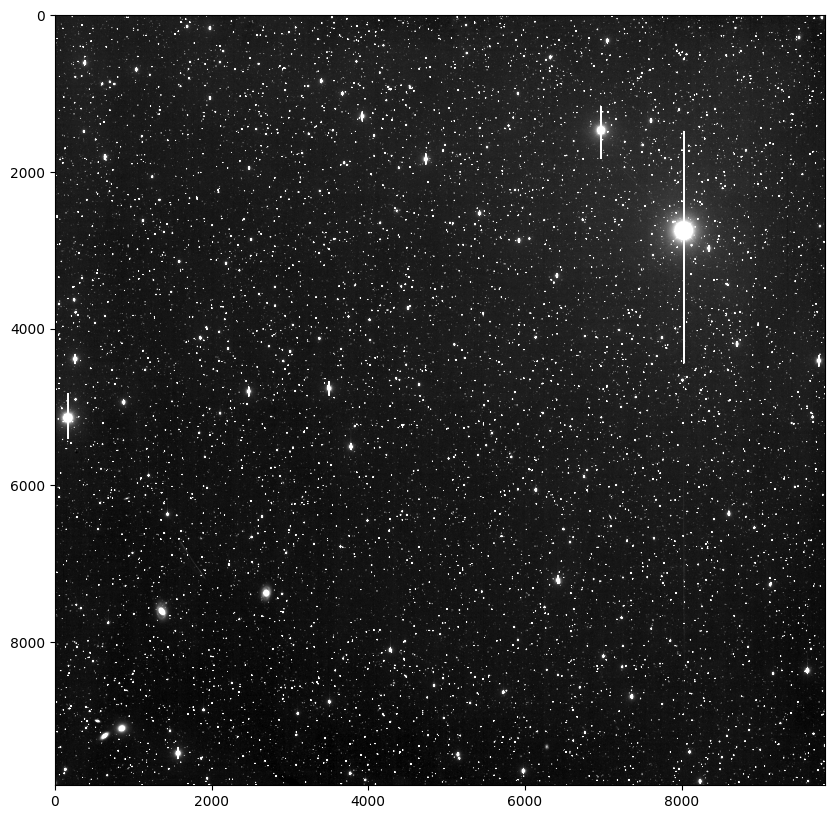

In [37]:
# plot the sci image and a circle around the center of each star in catalog
xmin = 0; xmax = 1000
ymin = 0; ymax = 1000
plt.figure(figsize=(10,10))
plt.imshow(sci[xmin:xmax,xmin,xmax], cmap='gray', vmin=250, vmax=400)

cropped_res = res.loc[res.]

for i in range(len(catalog)):
    plt.plot(catalog['x'][i], catalog['y'][i], 'ro', markersize=10, alpha=0.5)







In [58]:
res['DEC'].min()

7.65796982

In [28]:
help(ATLAS_Parser)

Help on ATLASParser in module __main__ object:

class ATLASParser(builtins.object)
 |  ATLASParser(working_path, image_type='science', crop_params=None, align=True)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, working_path, image_type='science', crop_params=None, align=True)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  correct_header(self, header)
 |  
 |  get_image(self, file)
 |  
 |  load_images(self, im_list, save=True)
 |  
 |  oversample_array(self, array)
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  arcsecmin_to_pxday(arcsecmin, pxsize=1.86)
 |  
 |  astrometrize(sources, im_shape, scale)
 |  
 |  center(im, header, coords, size=1000)
 |  
 |  crop_image(im, header, coords, size=1000)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (i

-- --
WCS tests
-- --

In [10]:
wcs_arrays = []
for im in sci_filelist: wcs_arrays.append(WCS(ATLAS_Parser.correct_header(fits.getheader(im ,1))))

 [astropy.io.fits.verify]


In [ ]:
# create linear trajectories
def createTraj(v: float, theta: float, t: float) -> np.array:
    T = np.array([v * np.cos(theta), v * np.sin(theta), t * v * np.cos(theta), t * v * np.sin(theta)])
    return T


def getTrajPos(self, t: np.array, i: int) -> np.array:
    time = self.stack[i].getTimes()
    return np.array([t[0] + time * t[1], t[2] + time * t[3]])

def getMultTrajPos(self, t: np.array):
    results = []
    num_times = len(self.stack)
    for i in range(num_times):
        pos = self.getTrajPos(t, i)
        results.append(pos)
    return np.array(results)

In [16]:
%%time
wcs_arrays[0].all_world2pix(159.833333333,10.43944444444,0,quiet=True)  

CPU times: user 448 µs, sys: 399 µs, total: 847 µs
Wall time: 688 µs


[array(5271.66916274), array(5287.57104512)]

In [15]:
crop_params

{'center_coords': (159.83333333333334, 10.439444444444444), 'crop_size': 8192}